In [1]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [2]:
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
sns.reset_orig() # don't change the style of plots

import glob
import datetime
import matplotlib.dates as mdates

from collections import OrderedDict
from matplotlib.gridspec import GridSpec
from mpl_toolkits.basemap import Basemap

In [3]:
cwd = os.getcwd()
os.chdir(r"C:\Users\heyde\Documents\02 - Job Applications\DataTonic Challenge\inputs")
cwd = os.getcwd()

csv_files = glob.glob('*.csv')
csv_files

['flights_large.csv', 'flights_medium.csv', 'weather.csv']

It’s up to you.  
Try putting yourself in the shoes of someone interested in getting insights or predictions out of this dataset. Some examples: 
*	What is the trend over time in number of flights and in delay times? Total US and per region?
*	Which airports/states/routes have the most delays?
*	Can flight delays be accurately predicted with machine learning?

Success criteria:  

Some ideas... 
*	Focus on efficient transformation and integration of the data
*	Focus on a well performing machine learning algorithm. 
*	Focus on an effective communication of your findings



### Some notes on the formatting of the notebook.

suffixes:
* \_df = pandas dataframe
* \_s = pandas Series
* \_ls = list

In [4]:
flights_df = pd.read_csv(csv_files[0])
weather_df = pd.read_csv(csv_files[2])

### flights.csv
---

In [34]:
flights_df.head(2)

,Date,Airline,Airline_code,Arrival_airport,Arrival_state,Departure_Airport,Departure_State,Departure_actual,Departure_delay,Arrival_actual,Arrival_delay,Arrival_schedule,Departure_schedule,DC_Longitude,DC_Latitude,Longitude,Latitude,Route,Path_order
0,2010-12-27,HA,19690,SAN,CA,HNL,HI,1311,1,2047,12,2035.0,1310.0,-157.92,21.31,-157.92,21.31,HI to CA,1
1,2004-04-10,HA,19690,SAN,CA,HNL,HI,1336,11,2146,11,2135.0,1325.0,-157.92,21.31,-157.92,21.31,HI to CA,1


In [5]:
flights_df['Date'] = pd.to_datetime(flights_df['Date'])

In [6]:
flights_df.nunique()

Date                  3987
Airline                 23
Airline_code            23
Arrival_airport         67
Arrival_state           32
Departure_Airport      234
Departure_State         52
Departure_actual      1416
Departure_delay        948
Arrival_actual        1440
Arrival_delay          993
Arrival_schedule      1390
Departure_schedule    1192
DC_Longitude           232
DC_Latitude            222
Longitude              233
Latitude               223
Route                  586
Path_order               2
dtype: int64

**Notes**:
* 234 departure Airports but only 67 Arrival airports.
* 23 airlines in our data


**Question to answer**
* difference between `DC_Longitude` and `Longitude`
* difference between `DC_Latitude` and `Latitude`
* Path-order?

In [7]:
flights_df[flights_df.DC_Longitude != flights_df.Longitude].tail(2)

,Date,Airline,Airline_code,Arrival_airport,Arrival_state,Departure_Airport,Departure_State,Departure_actual,Departure_delay,Arrival_actual,Arrival_delay,Arrival_schedule,Departure_schedule,DC_Longitude,DC_Latitude,Longitude,Latitude,Route,Path_order
9894840,2010-04-24,WN,19393,TUL,OK,DAL,TX,1421,16,1512,7,1505.0,1405.0,-96.85,32.84,-95.88,36.19,TX to OK,2
9894841,2003-10-03,WN,19393,TUL,OK,DAL,TX,1730,0,1825,0,1825.0,1730.0,-96.85,32.84,-95.88,36.19,TX to OK,2


## EDA - Explanatory Data Analysis
---

_To measure the trend of delays within time, we need to take it in account it with the trend of number of flights._  


In [8]:
## Largest Airports

# By Departure
DepAirport_df = pd.DataFrame(flights_df['Departure_Airport'].value_counts())
DepAirport_df.columns = ['Number_of_departures']
# By Arrival
AriAirport_df = pd.DataFrame(flights_df['Arrival_airport'].value_counts())
AriAirport_df.columns = ['Number_of_arrivals']

## These values should be very-close. As if a plane lands it needs to take off. 
## However, we are keeping this seperate, as we have only 67 different Airports, where planes have arrived, 
## compared to 234 different Departure ones. 

In [9]:
DepAirport_df.head()

,Number_of_departures
ATL,755903
ORD,600014
DFW,588351
IAH,344271
SEA,271121


In [10]:
AriAirport_df.head()

,Number_of_arrivals
PHX,1214197
DEN,1050768
CLT,1041075
CVG,858405
PHL,747867


### Notes:
---
It looks like some Information is missing in our data, because we have a big disporportion of the number of flights arriving at an airport and flights departuring from the same airport.  This should be roughly the same as when a plane lands it also needs to take off #=> arrivals and departures should be the same for the airports, but they aren't.  


So, we should remember that we have such a bias in the data, or maybe we are missing something from the data --> maybe `Path_order` stands for some of the return flights? or maybe some of the airports changed codes -> **look deeper into that**

In [11]:
## airports with highest departure delays
flights_depdelays_df = flights_df[flights_df['Departure_delay'] > 0]
flights_depdelays_airport_df = flights_depdelays_df.groupby("Departure_Airport")\
    .agg({'Departure_delay' : ['count', np.mean]}).sort_values([('Departure_delay', 'count')], ascending = False)
    
flights_depdelays_airport_df.reset_index(inplace = True)
flights_depdelays_airport_df.columns = ['Airport', 'Number_of_delays', 'Mean_of_delays']
    
## airports with highest arrival delays
flights_aridelays_df = flights_df[flights_df['Arrival_delay'] > 0]
flights_aridelays_airport_df = flights_aridelays_df.groupby('Arrival_airport')\
    .agg({'Arrival_delay' : ['count', np.mean]}).sort_values([('Arrival_delay', 'count')], ascending = False)
    
flights_aridelays_airport_df.reset_index(inplace = True)
flights_aridelays_airport_df.columns = ['Airport', 'Number_of_delays', 'Mean_of_delays']

In [12]:
## Merged with the number of flights departure
flight_dep_airport_df = pd.merge(flights_depdelays_airport_df, DepAirport_df, left_on = "Airport", right_index = True)\
    .sort_values('Number_of_departures', ascending = False).set_index("Airport")
    
## Get the proportion of flights delayed to all flights    
flight_dep_airport_df['Proportion'] = round(flight_dep_airport_df['Number_of_delays']\
    .divide(flight_dep_airport_df['Number_of_departures']) * 100,2)  

## Apply Percentage formatting
flight_dep_airport_df['Proportion'] = pd.Series(["{0:.2f}%".format(val) for val in flight_dep_airport_df['Proportion']],\
                                                index = flight_dep_airport_df.index)

## Merged with the number of flights arrival
flight_ari_airport_df = pd.merge(flights_aridelays_airport_df, AriAirport_df, left_on = "Airport", right_index = True)\
    .sort_values('Number_of_arrivals', ascending = False).set_index("Airport")
    
## Get the proportion of flights delayed to all flights    
flight_ari_airport_df['Proportion'] = round(flight_ari_airport_df['Number_of_delays']\
    .divide(flight_ari_airport_df['Number_of_arrivals']) * 100,2)

## Apply percentage formatting
flight_ari_airport_df['Proportion'] = pd.Series(["{0:.2f}%".format(val) for val in flight_ari_airport_df['Proportion']],\
                                                index = flight_ari_airport_df.index)

In [13]:
print("Departure Delays:")
flight_dep_airport_df.head(5)

Departure Delays:


,Number_of_delays,Mean_of_delays,Number_of_departures,Proportion
Airport,,,,
ATL,329920,29.967674,755903,43.65%
ORD,253079,34.208891,600014,42.18%
DFW,232299,28.078188,588351,39.48%
IAH,134515,24.600855,344271,39.07%
SEA,108467,25.108300,271121,40.01%


In [14]:
print("Arrival Delays:")
flight_ari_airport_df.head(5)

Arrival Delays:


,Number_of_delays,Mean_of_delays,Number_of_arrivals,Proportion
Airport,,,,
PHX,464234,23.094588,1214197,38.23%
DEN,412388,27.111955,1050768,39.25%
CLT,427806,24.607820,1041075,41.09%
CVG,328261,26.700068,858405,38.24%
PHL,322134,34.385349,747867,43.07%


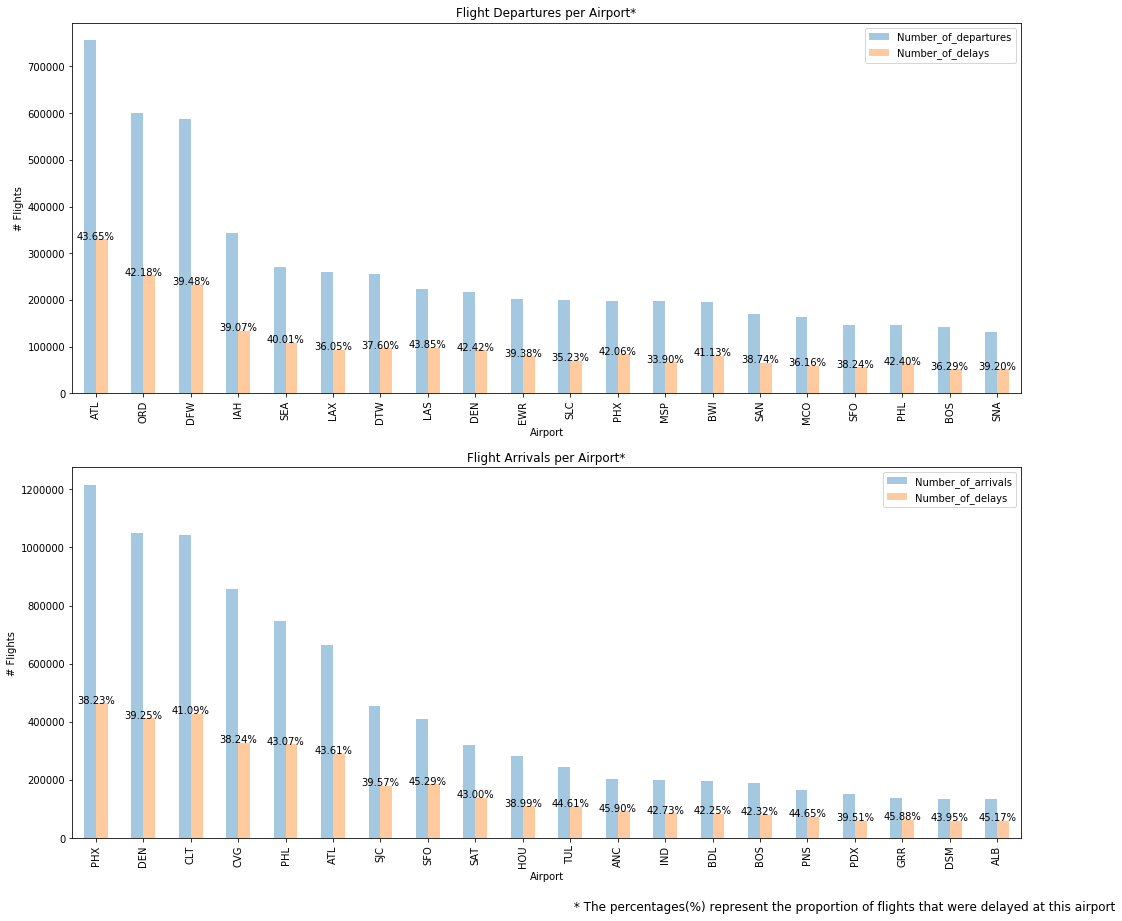

In [15]:
fig, axes = plt.subplots(figsize=(17, 15), nrows = 2, ncols =1)

font = {'weight': 'normal', 'size': 12}

#Plot 1
flight_dep_airport_df[['Number_of_departures', 'Number_of_delays']][:20].plot.bar(alpha=0.4, ax=axes[0])
    
for i, child in enumerate(axes[0].get_children()[20:40]):
    axes[0].text(i, child.get_bbox().y1, flight_dep_airport_df.sort_values(by = ['Number_of_departures'], ascending = False)\
                 .Proportion[i], horizontalalignment ='center')

#Plot2    
flight_ari_airport_df[['Number_of_arrivals', 'Number_of_delays']][:20].plot.bar(alpha=0.4, ax=axes[1])

for i, child in enumerate(axes[1].get_children()[20:40]):
    axes[1].text(i, child.get_bbox().y1, flight_ari_airport_df.sort_values(by = ['Number_of_arrivals'], ascending = False)\
                 .Proportion[i], horizontalalignment ='center')

    #row and    
axes[0].set_title('Flight Departures per Airport*')
axes[0].set_ylabel("# Flights");
axes[1].set_title('Flight Arrivals per Airport*')
axes[1].set_ylabel("# Flights");
axes[1].text(10, -250000, r' * The percentages(%) represent the proportion of flights that were delayed at this airport', fontdict=font);

In [16]:
Departure_Airports_df = flights_df[['Departure_Airport', 'DC_Longitude', 'DC_Latitude']].drop_duplicates().sort_values('Departure_Airport')
Departure_Airports_df.reset_index(drop = True, inplace = True)

count_flights = flights_df['Departure_Airport'].value_counts()

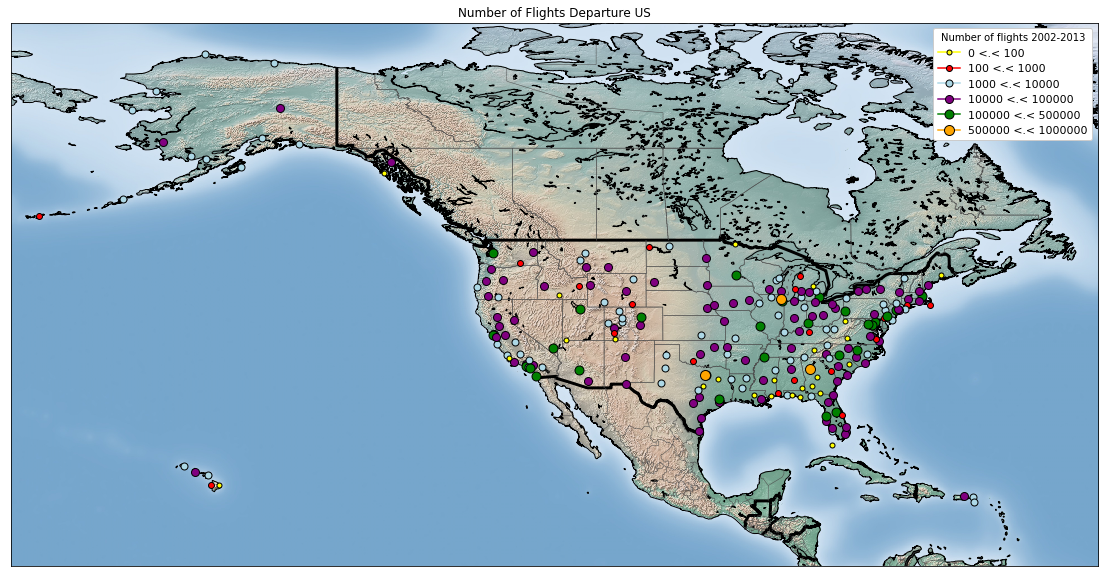

In [17]:
colors = ['yellow', 'red', 'lightblue', 'purple', 'green', 'orange', 'black']
size_limits = [0, 100, 1000, 10000, 100000, 500000, 1000000]

labels = []
for i in range(len(size_limits)-1):
    labels.append("{} <.< {}".format(size_limits[i], size_limits[i+1]))
    
#-----------------------------------------------
plt.figure(figsize=(20,10))

map = Basemap(resolution='i',llcrnrlon=-180, urcrnrlon=-50,
              llcrnrlat=10, urcrnrlat=75, lat_0=0, lon_0=0,)
map.shadedrelief()
map.drawcoastlines()
map.drawcountries(linewidth = 3)
map.drawstates(color='0.3')

#_____________________
# put airports on map
for index, (code, y,x) in Departure_Airports_df[['Departure_Airport', 'DC_Latitude', 'DC_Longitude']].iterrows():
    x, y = map(x, y)
    isize = [i for i, val in enumerate(size_limits) if val < count_flights[code]]
    ind = isize[-1]
    map.plot(x, y, marker='o', markersize = ind+5, markeredgewidth = 1, color = colors[ind],
             markeredgecolor='k', label = labels[ind])
    
handles, labels = plt.gca().get_legend_handles_labels()
by_label = OrderedDict(zip(labels, handles))
key_order = ('0 <.< 100', '100 <.< 1000', '1000 <.< 10000',
             '10000 <.< 100000','100000 <.< 500000', '500000 <.< 1000000')
new_label = OrderedDict()

plt.title("Number of Flights Departure US")
for key in key_order:
    new_label[key] = by_label[key]
plt.legend(new_label.values(), new_label.keys(), loc = 1, prop= {'size':11},
           title='Number of flights 2002-2013', frameon = True, framealpha = 1);

In [18]:
Arrival_Airports_df = pd.DataFrame(flights_df['Arrival_airport'].unique())
Arrival_Airports_df.columns = ['Airport']
Arrival_Airports_df = pd.merge(Arrival_Airports_df, Departure_Airports_df[['Departure_Airport', 'DC_Longitude', 'DC_Latitude']],\
         left_on = "Airport", right_on = "Departure_Airport").drop("Departure_Airport", axis = 1)
count_flights2 = flights_df['Arrival_airport'].value_counts()

In [19]:
##This dataframe shruck after the inner join - meaning we don't have some longitude, latitude for some arrival airport [22 cases]
print(len(count_flights2 ))
print(len(Arrival_Airports_df))

67
46


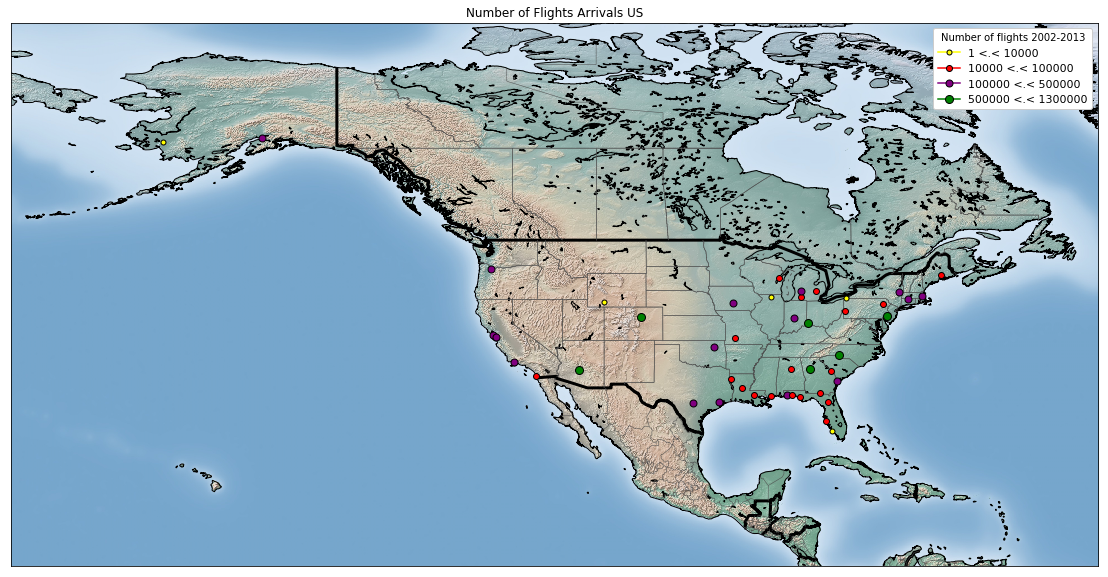

In [20]:
colors = ['yellow', 'red', 'purple', 'green', 'orange', 'black']
size_limits = [1, 10000, 100000, 500000, 1300000]

labels = []
for i in range(len(size_limits)-1):
    labels.append("{} <.< {}".format(size_limits[i], size_limits[i+1]))
    
#-----------------------------------------------
plt.figure(figsize=(20,10))

map1 = Basemap(resolution='i',llcrnrlon=-180, urcrnrlon=-50,
              llcrnrlat=10, urcrnrlat=75, lat_0=0, lon_0=0,)
map1.shadedrelief()
map1.drawcoastlines()
map1.drawcountries(linewidth = 3)
map1.drawstates(color='0.3')

#_____________________
# put airports on map
for index, (code, y,x) in Arrival_Airports_df[['Airport', 'DC_Latitude', 'DC_Longitude']].iterrows():
    x, y = map(x, y)
    isize = [i for i, val in enumerate(size_limits) if val < count_flights2[code]]
    ind = isize[-1]
    map1.plot(x, y, marker='o', markersize = ind+5, markeredgewidth = 1, color = colors[ind],
             markeredgecolor='k', label = labels[ind])
    
handles, labels = plt.gca().get_legend_handles_labels()
by_label = OrderedDict(zip(labels, handles))
key_order = ('1 <.< 10000', '10000 <.< 100000','100000 <.< 500000', '500000 <.< 1300000')
new_label = OrderedDict()
plt.title("Number of Flights Arrivals US")

for key in key_order:
    new_label[key] = by_label[key]
plt.legend(new_label.values(), new_label.keys(), loc = 1, prop= {'size':11},
           title='Number of flights 2002-2013', frameon = True, framealpha = 1);

### Time-Series
---

In [21]:
## No of Flights
flights_TimeSeries_df = pd.DataFrame({"Number_of_flights" : flights_df['Date'].value_counts().sort_index()})
flights_TimeSeries_df['Depature_delays'] = flights_depdelays_df['Date'].value_counts()
flights_TimeSeries_df['Arrival_delays'] = flights_aridelays_df['Date'].value_counts()

##Cumulative

flights_TimeSeries_df['Cumulative_flights'] = flights_TimeSeries_df['Number_of_flights'].cumsum()
flights_TimeSeries_df['Cumulative_departure_delays'] = flights_TimeSeries_df['Depature_delays'].cumsum()
flights_TimeSeries_df['Cumulative_arrival_delays'] = flights_TimeSeries_df['Arrival_delays'].cumsum()

##Proportion of delay
flights_TimeSeries_df['Dep_delays_proportion'] = round(flights_TimeSeries_df['Cumulative_departure_delays']\
    .divide(flights_TimeSeries_df['Cumulative_flights'])*100,1)

flights_TimeSeries_df['Ari_delays_proportion'] = round(flights_TimeSeries_df['Cumulative_arrival_delays']\
    .divide(flights_TimeSeries_df['Cumulative_flights'])*100,1)


In [22]:
flights_TimeSeries_df.head(2)

,Number_of_flights,Depature_delays,Arrival_delays,Cumulative_flights,Cumulative_departure_delays,Cumulative_arrival_delays,Dep_delays_proportion,Ari_delays_proportion
2002-01-01,1977,866,831,1977,866,831,43.8,42.0
2002-01-02,1986,1185,1176,3963,2051,2007,51.8,50.6


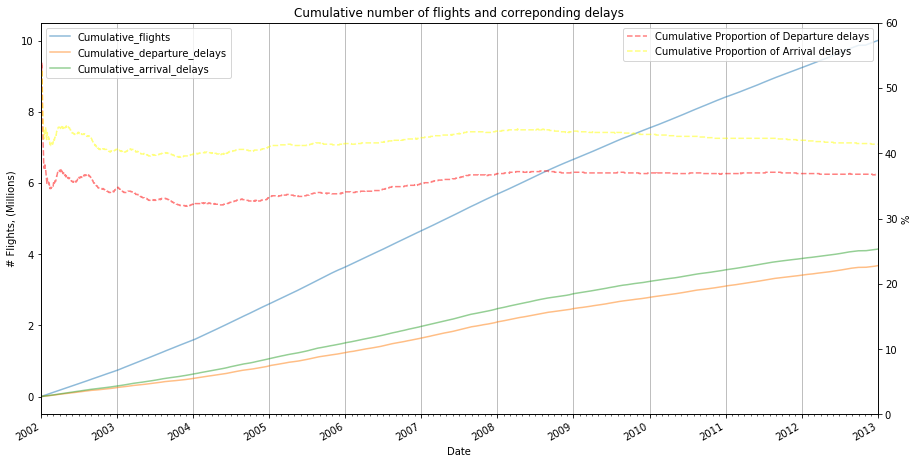

In [23]:
days = mdates.DayLocator()
months = mdates.MonthLocator()
years = mdates.YearLocator()

fig, ax = plt.subplots(figsize=(15, 8))

flights_TimeSeries_df[['Cumulative_flights','Cumulative_departure_delays','Cumulative_arrival_delays']]\
    .divide(1000000).plot(alpha = 0.5, ax = ax)

ax2 = ax.twinx()

flights_TimeSeries_df['Dep_delays_proportion'][4:].plot(alpha = 0.5,linestyle='--', color='red', ax = ax2, label = "Cumulative Proportion of Departure delays")
flights_TimeSeries_df['Ari_delays_proportion'][4:].plot(alpha = 0.5,linestyle='--', color='yellow', ax = ax2, label = "Cumulative Proportion of Arrival delays")

ax2.set_ylim(0,60)
ax2.set_ylabel("%")
ax2.legend()

ax.format_xdata = mdates.DateFormatter('%Y-%m-%d')
ax.xaxis.set_major_locator(years)
ax.set_title("Cumulative number of flights and correponding delays")
ax.set_xlabel("Date")
ax.set_ylabel("# Flights, (Millions)");

ax.set_xlim([datetime.date(2002, 1, 1), datetime.date(2013, 1, 1)]);
ax.xaxis.set_minor_locator(months)
ax.xaxis.grid(True)

## Observations by now:
---
Time range: 2002 -> 2013


* The number of flights is increasing over the time range, so are the delays.
* However, the cumulative proportion of delayed flights has not changed over the years. There hasn't been any significant improvement of the average number of delays. #=> we shouldn't rely much on the cumulative proportion, as if there would be have been an improvement in the last years, it would be hard to discover, because of the "magnitude" of data. **Do: Year-to-Year analysis**


* The departure and arrival delay counts are really similiar. However the magnitude of Arrival delays at the end is a bit large, meaning that some flights have only arrival delays but no departure delays => the delays is caused while flying.


* The cumulative number of delays is increasing linearly, meaning that the delays for years are quite similiar. No year is much different than another. Maybe the slope tends to be higher(steeper) in 2007,2008; and lower in first and last years. **check it next- year-to-year analysis**

### Year-to-year Analysis
---

In [24]:
flights_yearly_timeSeries_df = flights_TimeSeries_df[['Number_of_flights', 'Depature_delays', 'Arrival_delays']].resample('Y').sum().reset_index()
flights_yearly_timeSeries_df.columns = ["Date",'Number_of_flights', 'Depature_delays', 'Arrival_delays']
flights_yearly_timeSeries_df['Year'] = flights_yearly_timeSeries_df['Date'].dt.strftime('%Y')
flights_yearly_timeSeries_df.set_index("Year", inplace = True)
flights_yearly_timeSeries_df.drop('Date', axis = 1, inplace = True)

flights_yearly_timeSeries_df['Dep_delay_prop'] = \
    round(flights_yearly_timeSeries_df['Depature_delays'].divide(flights_yearly_timeSeries_df['Number_of_flights'])*100,1)
flights_yearly_timeSeries_df['Ari_delay_prop'] = \
    round(flights_yearly_timeSeries_df['Arrival_delays'].divide(flights_yearly_timeSeries_df['Number_of_flights'])*100,1)

In [25]:
flights_yearly_timeSeries_df.head()

,Number_of_flights,Depature_delays,Arrival_delays,Dep_delay_prop,Ari_delay_prop
Year,,,,,
2002,733686,254235,297764,34.7,40.6
2003,850784,255935,333456,30.1,39.2
2004,1016971,355014,435168,34.9,42.8
2005,1036311,373463,443071,36.0,42.8
2006,1017223,407381,463120,40.0,45.5


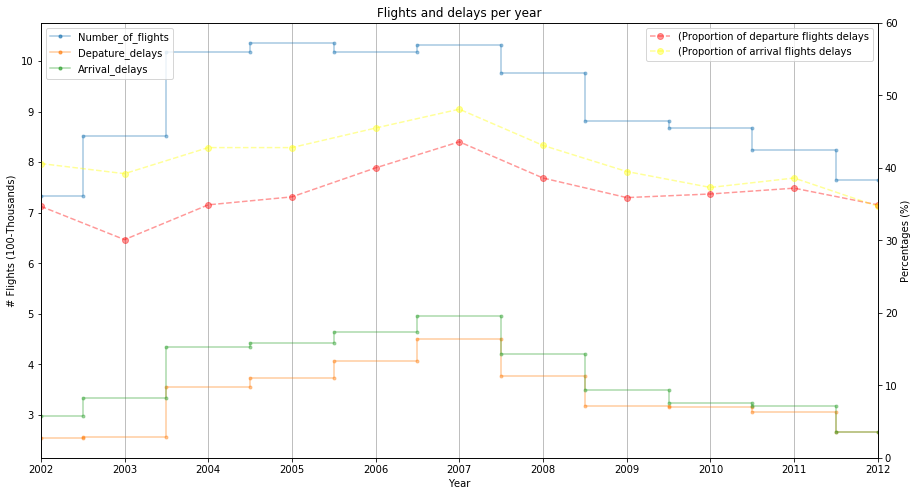

In [26]:
fig, ax = plt.subplots(figsize=(15, 8))

ax.step(flights_yearly_timeSeries_df.index, flights_yearly_timeSeries_df['Number_of_flights'].divide(100000),\
             alpha=0.4, marker = '.', where = 'mid')
ax.step(flights_yearly_timeSeries_df.index, flights_yearly_timeSeries_df['Depature_delays'].divide(100000),\
             alpha=0.4, marker = '.', where = 'mid')
ax.step(flights_yearly_timeSeries_df.index, flights_yearly_timeSeries_df['Arrival_delays'].divide(100000),\
             alpha=0.4, marker = '.', where = 'mid')

ax2 = ax.twinx()
ax2.plot(flights_yearly_timeSeries_df.index, flights_yearly_timeSeries_df['Dep_delay_prop'],\
             alpha=0.4, marker = 'o',linestyle='--', color='red', label = "(Proportion of departure flights delays")
ax2.plot(flights_yearly_timeSeries_df.index, flights_yearly_timeSeries_df['Ari_delay_prop'],\
             alpha=0.4, marker = 'o',linestyle='--', color='yellow', label = "(Proportion of arrival flights delays")

ax2.set_ylim(0,60)
ax2.set_ylabel("Percentages (%)")

ax.set_title("Flights and delays per year")
ax.set_xlabel("Year")
ax.set_ylabel("# Flights (100-Thousands)");
ax.set_xlim(2002,2012)
ax.xaxis.grid(True)
ax.legend(loc = 2);
ax2.legend();

## Notes:
---

## Merging Dataframes - Flights + Weather
---

**First option to consider**

In [27]:
weather_df[weather_df.airport == "ORD"].sort_values(['Date','time']).head(10)

,Date,airport,time,temperature,snow,wind
33684290,2005-01-01,ORD,9,33,NaN,7.6
21367220,2005-01-01,ORD,28,33,NaN,7.6
21368956,2005-01-01,ORD,30,33,NaN,7.6
33648236,2005-01-01,ORD,53,33,NaN,7.6
29551691,2005-01-01,ORD,359,33,NaN,7.6
3654241,2005-01-01,ORD,413,33,NaN,7.6
35014428,2005-01-01,ORD,415,33,NaN,7.6
11812667,2005-01-01,ORD,435,33,NaN,7.6
32318825,2005-01-01,ORD,439,33,NaN,7.6
32282182,2005-01-01,ORD,448,33,NaN,7.6


In [28]:
## FIRST LETS TRY THIS OPTION - maybe a better exist and we will come up with it later.
weather1_df = weather_df.copy()
## drop the observations that have the same measures on the same day, but only the time differs.. 
weather1_df.drop_duplicates(['Date', 'airport', 'temparature', 'snow', 'wind'], inplace = True)

In [29]:
weather1_df.head()

,Date,airport,time,temperature,snow,wind
0,2006-03-14,ORD,2041,35,NaN,18.6
1,2006-09-08,SLC,807,72,NaN,6.5
2,2006-10-22,MCO,1202,81,0.0,3.1
4,2007-07-09,MRY,1011,64,NaN,0.7
5,2006-08-01,IAH,1256,85,NaN,5.1


### Second option - Merge asof
---

In [30]:
flights_df.head()

,Date,Airline,Airline_code,Arrival_airport,Arrival_state,Departure_Airport,Departure_State,Departure_actual,Departure_delay,Arrival_actual,Arrival_delay,Arrival_schedule,Departure_schedule,DC_Longitude,DC_Latitude,Longitude,Latitude,Route,Path_order
0,2010-12-27,HA,19690,SAN,CA,HNL,HI,1311,1,2047,12,2035.0,1310.0,-157.92,21.31,-157.92,21.31,HI to CA,1
1,2004-04-10,HA,19690,SAN,CA,HNL,HI,1336,11,2146,11,2135.0,1325.0,-157.92,21.31,-157.92,21.31,HI to CA,1
2,2004-04-29,HA,19690,SAN,CA,HNL,HI,1404,39,2223,48,2135.0,1325.0,-157.92,21.31,-157.92,21.31,HI to CA,1
3,2008-09-09,HA,19690,SAN,CA,HNL,HI,1333,-2,2147,-3,2150.0,1335.0,-157.92,21.31,-157.92,21.31,HI to CA,1
4,2011-03-30,HA,19690,SAN,CA,HNL,HI,1314,-1,2158,23,2135.0,1315.0,-157.92,21.31,-157.92,21.31,HI to CA,1


In [31]:
weather_df.head()

,Date,airport,time,temperature,snow,wind
0,2006-03-14,ORD,2041,35,NaN,18.6
1,2006-09-08,SLC,807,72,NaN,6.5
2,2006-10-22,MCO,1202,81,0.0,3.1
3,2006-10-22,MCO,602,81,0.0,3.1
4,2007-07-09,MRY,1011,64,NaN,0.7


In [32]:
pd.mergeasof(flights, weather, left_on = ['Date', 'Arr'])

AttributeError: module 'pandas' has no attribute 'mergeasof'

## ML - delay prediction
---

As our data for departures look more reliable we will focus on that part!